In [12]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import json

In [13]:
df = pd.read_csv('training_data.csv')
df['YearMonth'] = pd.to_datetime(df['YearMonth'])

In [14]:
# project feature values
def project_feature_values(data, steps):
    x = np.arange(len(data))
    y = data.values
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    future_values = m * (np.arange(len(data), len(data) + steps)) + c
    return future_values

In [15]:
# Select features
def select_features(X, y, k=10):
    if len(X) <= k:
        return X.columns.tolist()  
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores.head(k).index.tolist()

In [16]:
def prepare_data_for_prophet(df, zipcode):
    zipcode_data = df[df['zipcode'] == zipcode].sort_values('YearMonth')
    if len(zipcode_data) < 24: # check data
        return None, None
    
    prophet_df = zipcode_data[['YearMonth', 'AveragePrice']].rename(columns={'YearMonth': 'ds', 'AveragePrice': 'y'})
    
    additional_features = ['ArrestCount', 'NoiseComplaints', 'count', 'distance_to_facility',
                           'cultural_facility', 'education_facility', 'health_services',
                           'public_safety', 'recreational_facility', 'religious_institution',
                           'transportation_facility', 'population', 'average_household_income']
    
    X = zipcode_data[additional_features]
    y = zipcode_data['AveragePrice']
    
    selected_features = select_features(X, y)
    
    for feature in selected_features:
        prophet_df[feature] = zipcode_data[feature]
    
    return prophet_df, selected_features

In [17]:
# Fit prophet model and predict 
def fit_and_predict_prophet(data, selected_features, steps=60):
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    
    for feature in selected_features:
        model.add_regressor(feature)
    
    model.fit(data)
    
    future = model.make_future_dataframe(periods=steps, freq='M')
    
    for feature in selected_features:
        future[feature] = np.concatenate([data[feature], project_feature_values(data[feature], steps)])
    
    forecast = model.predict(future)
    return forecast, model

In [18]:
# ROI
def calculate_roi(initial_price, final_price):
    return (final_price - initial_price) / initial_price

In [19]:
def get_all_zipcode_scores(df, years=[1, 3, 5]):
    results = []
    for zipcode in df['zipcode'].unique():
        zipcode_data, selected_features = prepare_data_for_prophet(df, zipcode)
        if zipcode_data is None:
            continue
        
        current_price = zipcode_data['y'].iloc[-1]
        forecast, _ = fit_and_predict_prophet(zipcode_data, selected_features)
        
        roi_results = {}
        for year in years:
            future_price = forecast['yhat'].iloc[12*year - 1]
            roi = calculate_roi(current_price, future_price)
            roi_lower = calculate_roi(current_price, forecast['yhat_lower'].iloc[12*year - 1])
            roi_upper = calculate_roi(current_price, forecast['yhat_upper'].iloc[12*year - 1])
            roi_results[f'{year}Yr_ROI'] = roi
            roi_results[f'{year}Yr_ROI_Lower'] = roi_lower
            roi_results[f'{year}Yr_ROI_Upper'] = roi_upper
        
        historical_forecast = forecast[:len(zipcode_data)]
        mae = mean_absolute_error(zipcode_data['y'], historical_forecast['yhat'])
        r2 = r2_score(zipcode_data['y'], historical_forecast['yhat'])
        
        results.append({
            'zipcode': int(zipcode),
            'borough': df[df['zipcode'] == zipcode]['Borough'].iloc[0],
            'current_price': float(current_price),
            'MAE': float(mae),
            'R²': float(r2),
            **{key: float(value) for key, value in roi_results.items()}
        })
    
    # Save  to JSON
    with open('zipcode_scores_prophet_updated.json', 'w') as f:
        json.dump(results, f, indent=4)

In [20]:
get_all_zipcode_scores(df)

16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing

# Plot with User Input

In [ ]:
# Plot
def plot_forecast_prophet(df, zipcode, forecast):
    plt.figure(figsize=(12, 6))
    historical_data, _ = prepare_data_for_prophet(df, zipcode)
    plt.plot(historical_data['ds'], historical_data['y'], label='Historical')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
    plt.title(f'Housing Price Forecast for Zipcode {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend()
    plt.show()

In [ ]:
# Run 
def run_analysis_prophet(df, borough, max_price):
    top_zipcodes = get_top_zipcodes_prophet(df, borough, max_price)
    print(f"Top 5 Zipcodes in {borough} under ${max_price:,}:")
    print(top_zipcodes[['zipcode', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI', 'MAE', 'R²', 'selected_features']])
    
    for _, row in top_zipcodes.iterrows():
        zipcode = row['zipcode']
        zipcode_data, selected_features = prepare_data_for_prophet(df, zipcode)
        forecast, _ = fit_and_predict_prophet(zipcode_data, selected_features)
        plot_forecast_prophet(df, zipcode, forecast)

16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:09:09 - cmdstanpy - INFO - Chain [1] start processing
16:09:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:09:10 - cmdstanpy - INFO - Chain [1] start processing
16:09:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
16:09:11 - cmdstanpy - INFO - Chain [1] start processing
16:09:11 - cmdstanpy - INFO - Chain [1] done processing

Top 5 Zipcodes in Manhattan under $1,500,000:
    zipcode  current_price   1Yr_ROI   3Yr_ROI   5Yr_ROI           MAE  \
25    10035         599463  0.073056  0.210574  0.480815   9494.543978   
0     10001        1675072 -0.050065  0.109427  0.453290  32138.062515   
7     10014        1628708 -0.046658  0.108522  0.379089  29083.594185   
3     10005        1075476  0.091383  0.138280  0.332496   9508.940900   
10    10018        1306133 -0.101073  0.041499  0.325602  13126.424457   

          R²                                  selected_features  
25  0.996120  [population, average_household_income, ArrestC...  
0   0.992844  [average_household_income, population, ArrestC...  
7   0.990093  [population, average_household_income, ArrestC...  
3   0.993754  [population, average_household_income, ArrestC...  
10  0.996339  [population, average_household_income, ArrestC...  


16:09:38 - cmdstanpy - INFO - Chain [1] start processing
16:09:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


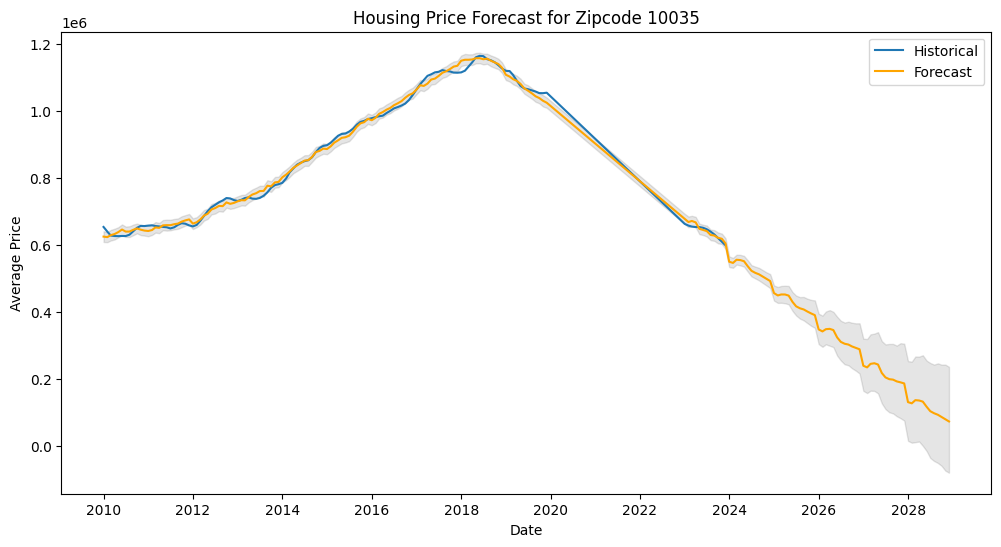

16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


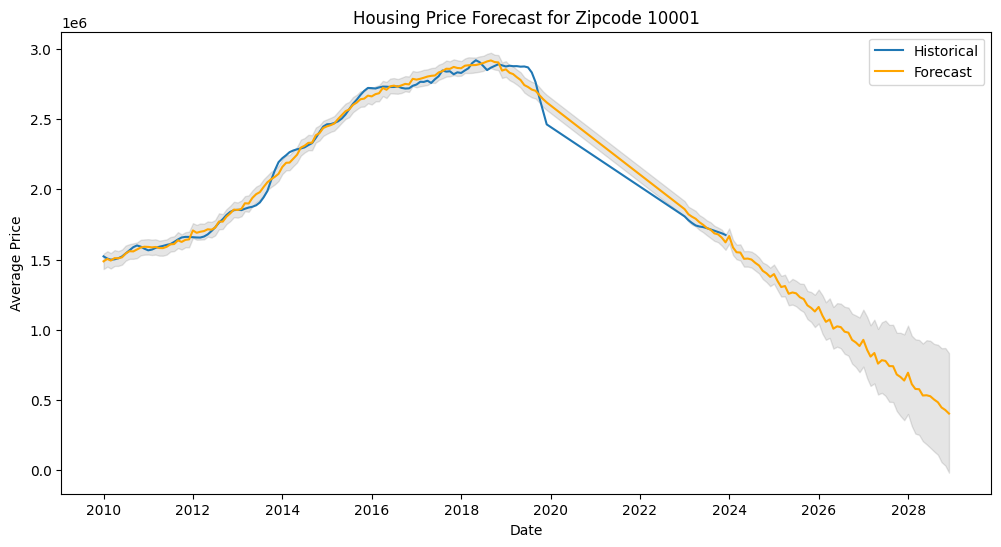

16:09:41 - cmdstanpy - INFO - Chain [1] start processing
16:09:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


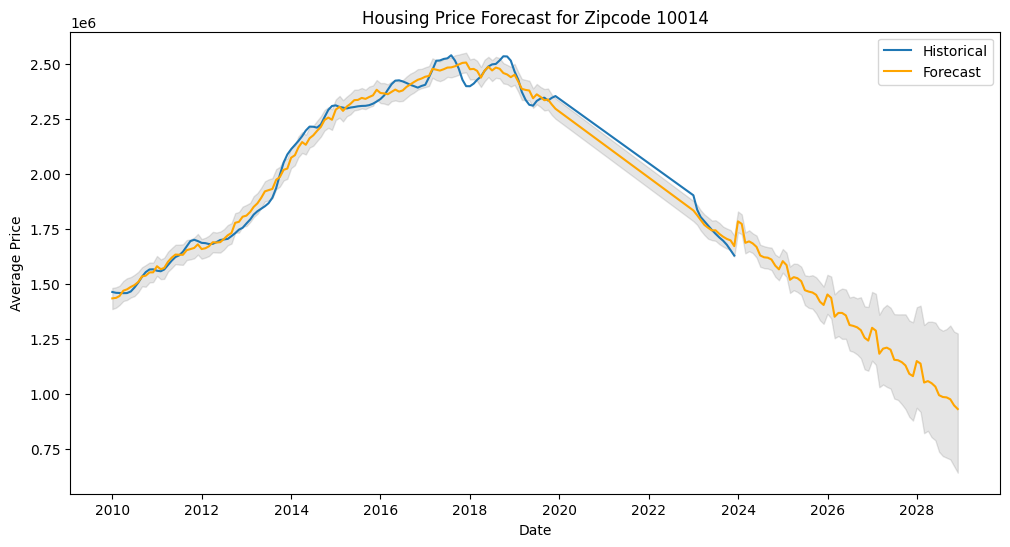

16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


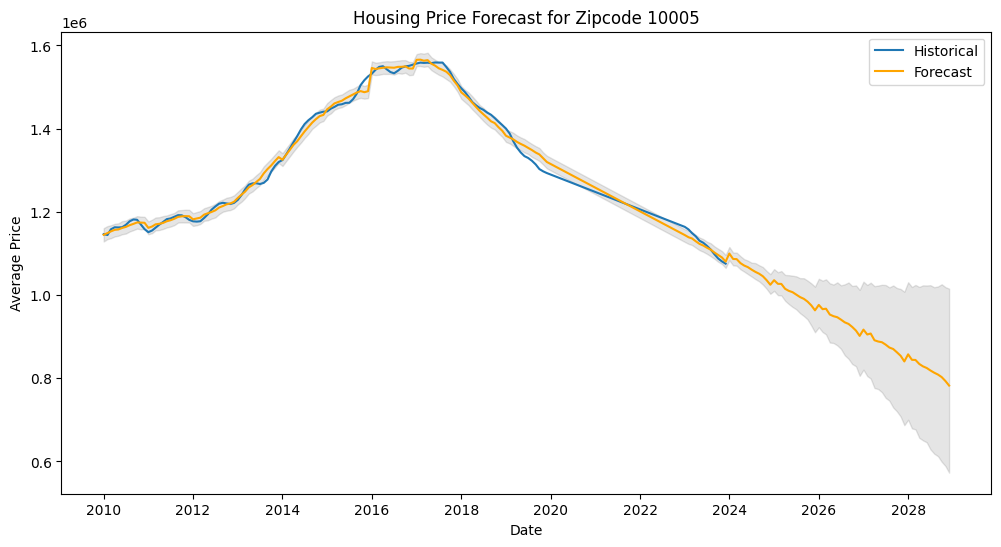

16:09:44 - cmdstanpy - INFO - Chain [1] start processing
16:09:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


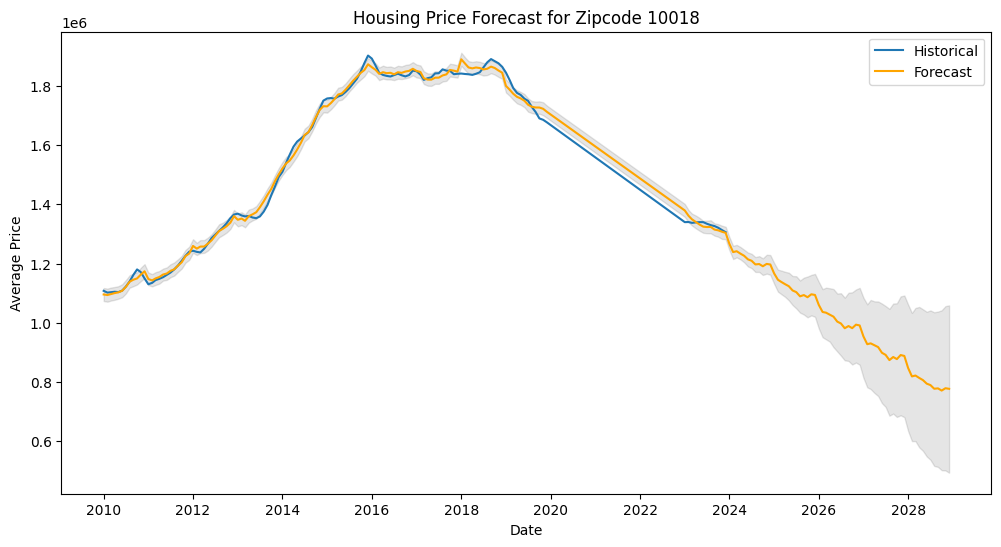

In [ ]:
# Example usage
borough = 'Manhattan' 
max_price = 1500000  

run_analysis_prophet(df, borough, max_price)